<p><center><h1>💶 Algorithme de détection automatique de faux billets</h1></center></p>
<p><center><h1>Partie 1 - Analyse</h1></center></p>

**ONCFM - Organisation nationale de lutte contre le faux-monnayage** est une organisation publique ayant pour objectif de mettre en place des méthodes d'identification des contrefaçons des billets en euros.
Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

## Objectifs

Lorsqu'un billet arrive, nous avons une machine qui consigne l'ensemble de ses caractéristiques géométriques. Au fil de nos années de lutte, nous avons observé des différences de dimensions entre les vrais et les faux billets. Ces différences sont difficilement visibles à l'oeil nu, mais une machine devrait sans problème arriver à les différencier.

Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques géométriques d'un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

<img src="../gfx/sep.jpg" alt="Barre">

## Chargement

***

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("colorblind")
sns.set_theme(style="darkgrid")

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Chargement des données
df = pd.read_csv("../data/billets.csv", sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<img src="../gfx/sep.jpg" alt="Barre">

## 1 - Analyse descriptive

***

### 1.1 - Description du jeu de données

Les données sont composées d'une variable cible : 
- **is_genuine**, détermine si le billet est vrai ou faux (true/false)

In [3]:
df['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Le jeu de données est composé de 1500 billets, répartis de la sorte :
- 1000 vrais billets
- 500 faux billets

Les données comportent également 6 variables predictifs, correspondant aux dimensions géométriques des billets :
- **diagonal**, la diagonal du billet (en mm)
- **height_left**, la hauteur du billet mesurée sur le côté gauche (en mm)
- **height_right**, la hauteur du billet mesurée sur le côté droit (en mm)
- **margin_low**, la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- **margin_up**, la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- **length**, la longueur du billet (en mm)

In [4]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [5]:
# Récupération du dataframe ne comportant que des variables numériques
df_num = df.select_dtypes(include='number')
indicateurs = df_num.columns

### 1.2 - Valeurs manquantes

In [6]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Seule la dimension **margin_low** comporte des valeurs manquantes.

Il nous faut inférer ces valeurs manquantes à l'aide d'une ***régression linéaire*** à partir des autres variables.

In [7]:
# Copie du dataframe sans les manquants de margin_low
df_mlna = df.copy()
df_mlna.dropna(subset=['margin_low'], inplace=True)

# Vérification des valeurs manquantes
df_mlna.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [8]:
# Conversion de la variable is_genuine en variable binaire
df_mlna['is_genuine'] = df_mlna['is_genuine'].astype('int')
df_mlna['is_genuine'].value_counts()

is_genuine
1    971
0    492
Name: count, dtype: int64

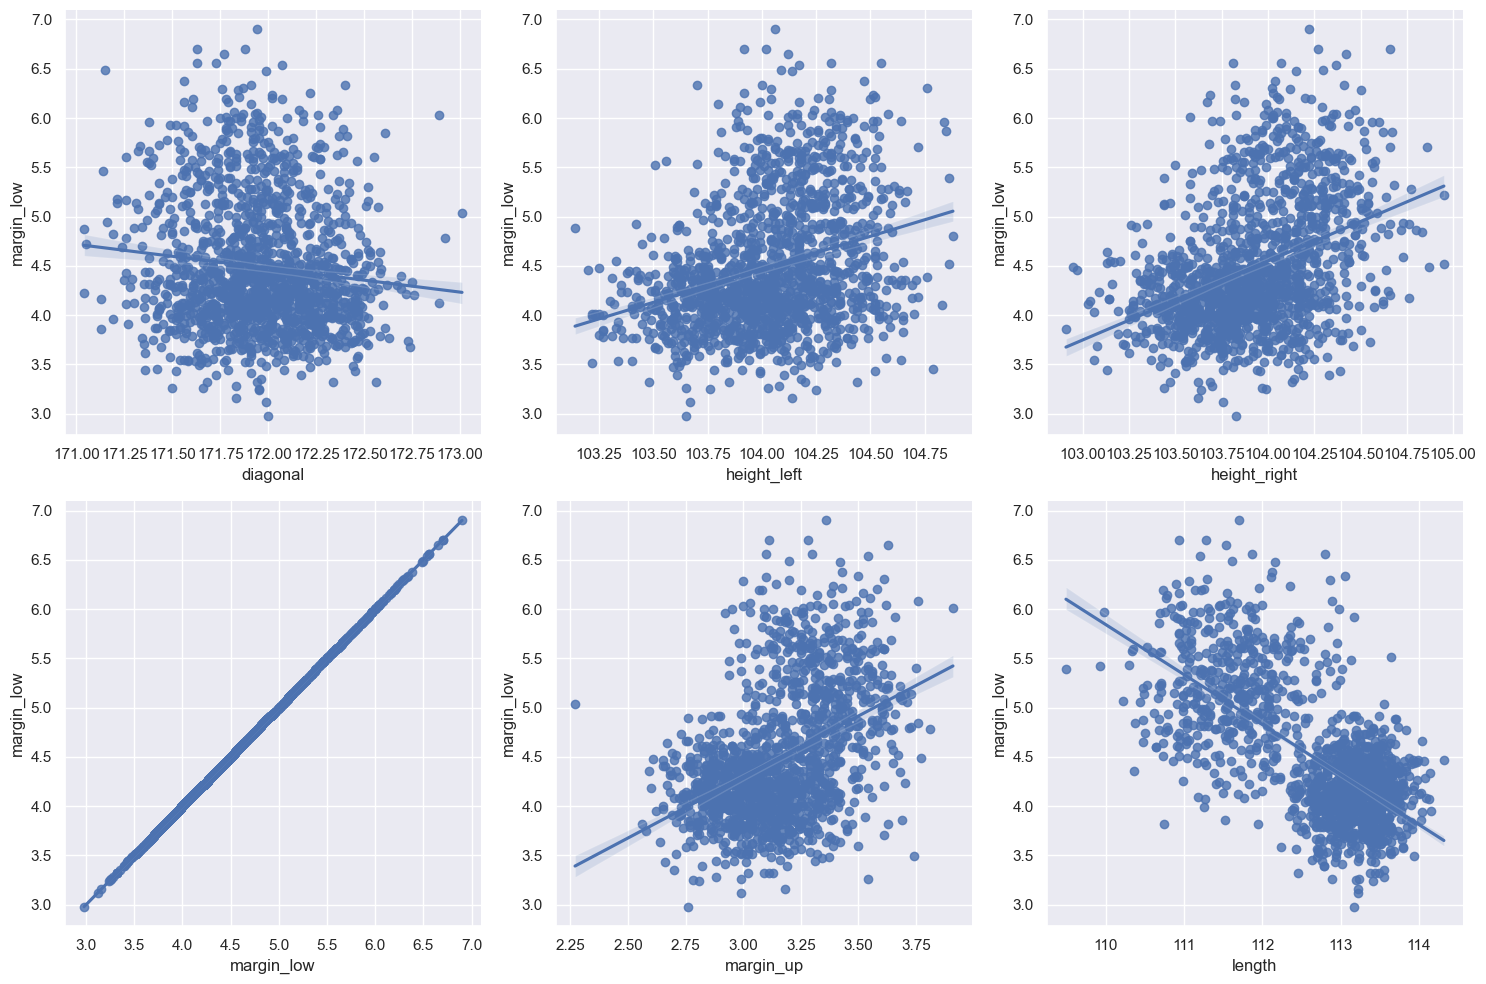

In [9]:
# Analyse bivariée
fig, ax = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    for j in range(3):
        sns.regplot(x=df_mlna[indicateurs[3*i+j]], y=df_mlna['margin_low'], ax=ax[i,j])
        plt.ylabel('margin_low')
        plt.xlabel(indicateurs[3*i+j])
        plt.grid()
        sns.despine()
    
plt.tight_layout()
plt.show()

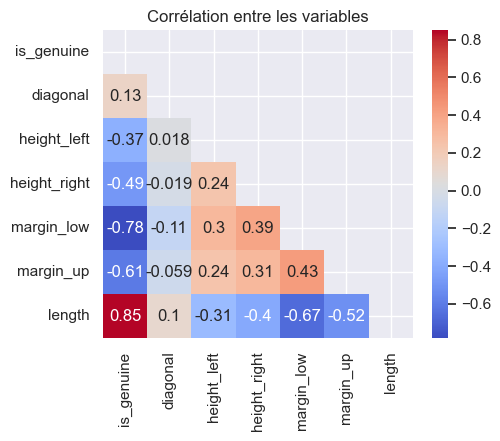

In [10]:
# Analyse des corrélations
correlation = df_mlna.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(5,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask)
plt.title('Corrélation entre les variables')
plt.show()

In [11]:
varpred = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Régression linéaire
reg = LinearRegression()
X = df_mlna[varpred]
y = df_mlna['margin_low']
reg.fit(X,y)

LinearRegression()

In [12]:
print(f"R^2 : {np.round(reg.score(X,y), 3)}")
print(f"margin_low = {np.round(reg.coef_[0], 2)} * is_genuine + {np.round(reg.coef_[1], 2)} * diagonal + {np.round(reg.coef_[2], 2)} * height_left + {np.round(reg.coef_[3], 2)} * height_right + {np.round(reg.coef_[4], 2)} * margin_up + {np.round(reg.coef_[5], 2)} * length + bruit")

R^2 : 0.617
margin_low = -1.14 * is_genuine + -0.01 * diagonal + 0.03 * height_left + 0.03 * height_right + -0.21 * margin_up + -0.0 * length + bruit


In [13]:
# Prédictions
y_pred = reg.predict(X)
print(f"MSE : {np.round(mean_squared_error(y, y_pred), 2)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y, y_pred), 2)}")

MSE : 0.17
MAPE : 0.07


In [15]:
# Utilisation d'un scaler pour contraindre les variables entre 0 et 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_mlna[varpred])
df_mlna_scaled = pd.DataFrame(X_scaled, columns=varpred)
df_mlna_scaled.describe().loc[['min', 'max']]

,is_genuine,diagonal,height_left,height_right,margin_up,length
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
# Scinder les données en jeu d'entraînement et de test
X = df_mlna_scaled[varpred]
y = df_mlna['margin_low']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [19]:
# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

# Scores
print(f"RMSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")

RMSE: 0.13739452871780827
MAPE: 0.06496074172211527


On a un très bon modèle.

### 1.3 - Valeurs aberrantes ou atypiques

In [ ]:
# Répartition des dimensions des billets
ind_j = 2
ind_i = int(len(indicateurs)/ind_j)
fig, ax = plt.subplots(ind_i, ind_j, figsize=(6,10))

for i in range(ind_i):
    for j in range(ind_j):
        sns.boxplot(data=df_num[indicateurs[ind_j*i+j]], ax=ax[i,j], width=0.5)

fig.tight_layout(pad=0.5)
plt.show()

In [7]:
# Copie du dataframe pour vérification par stats
df_stats = df_num.copy()
z_indicateurs = ['z_diagonal', 'z_height_left', 'z_height_right', 'z_margin_low', 'z_margin_up', 'z_length']

# Vérification avec le Z-Score
df_stats['z_diagonal'] = stats.zscore(df_stats.diagonal)
df_stats['z_height_left'] = stats.zscore(df_stats.height_left)
df_stats['z_height_right'] = stats.zscore(df_stats.height_right)
df_stats['z_margin_low'] = stats.zscore(df_stats.margin_low)
df_stats['z_margin_up'] = stats.zscore(df_stats.margin_up)
df_stats['z_length'] = stats.zscore(df_stats.length)

In [ ]:
# Histogramme des Z-Scores
fig, ax = plt.subplots(ind_i, ind_j, figsize=(6,8))

for i in range(ind_i):
    for j in range(ind_j):
        sns.histplot(data=df_stats[z_indicateurs[ind_j*i+j]], ax=ax[i,j])

fig.tight_layout(pad=0.5)
plt.show()

Les données dimensionnelles ne comportent ***pas de valeurs aberrantes ou atypiques***.